# Process Mining in Healthcare

In recent years, the systematisation of healthcare operations and the digitisation of medical records have led to the collection of an increasing amount of data from complex clinical processes. Additionally, there has been increasing interest in process optimisation and process debugging approaches to improve the effectiveness and quality of healthcare. These methods have been used to:

* identify processes, then describe them using process models. Such models can be represented using a variety of graphical languages, including Petri nets, direct-sequence graphs and business process models;

* examine the throughput and time spent on each event to discover bottlenecks and possibilities for improving efficiency;

* analyse the correspondence of actual procedures with recommended treatment practices and paths.

In [1]:
# Import the libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset:
events = pd.read_csv('Dataset.csv')
events.columns = ['patient', 'action', 'resource', 'datetime']
events['datetime'] = pd.to_datetime(events['datetime'])

# View the dataset:
print('The dataset has {} rows and {} columns.'.format(events.shape[0], events.shape[1]))
events.head()

The dataset has 690 rows and 4 columns.


,patient,action,resource,datetime
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11
1,patient 0,Blood test,Lab,2017-01-02 12:47:33
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09


Let us consider that our aim is to better understand the various patient paths. In this instance, cases would be associated with the patient column, events with the action column and resources with the resource column (but if the goal were different, we could choose a different mapping, for example we could treat the resource column as a case, if we were studying processes from the point of view of doctors rather than patients).

## Data Analysis

The calculation of the relative time of each event, that is the time at which the event occurs concerning the start of the process, is the first step in creating the event log.

In [2]:
# Create a pivot table containing the start (minimum) and end (maximum) times for each case:
cases_starts_ends = events.pivot_table(index='patient', aggfunc={'datetime': ['min', 'max']})
cases_starts_ends = cases_starts_ends.reset_index()
cases_starts_ends.columns = ['patient', 'case_end', 'case_start']

# Merge the main event log data, so that each line contains start and end times:
events = events.merge(cases_starts_ends, on='patient')

# Subtract the process start time from the event timestamp to determine the relative time:
events['relativetime'] = events['datetime'] - events['case_start']
events['relativetime_seconds'] = events['relativetime'].dt.seconds + 86400*events['relativetime'].dt.days
events['relativetime_days'] = events['relativetime'].dt.days

It is useful to visualise the events linked to each example in relative time to get a general idea of how the process appears. For this purpose, one can use a dot plot, which graphs the sequences of events of each instance against time.

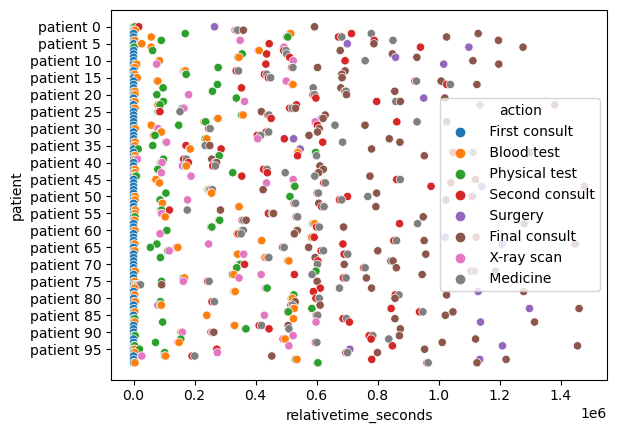

In [3]:
# Obtain a set of labels for the y-axis to label the graph:
patients_numbers = [int(number) for number in events['patient'].apply(lambda patient: patient.strip('patient'))]

# For greater readability, set the y-axis ticks, so that only one patient out of five is displayed:
plt.yticks(np.arange(min(patients_numbers), max(patients_numbers)+1, 5))

# Create a scatter plot showing the occurrences of patients with time:
sns.scatterplot(x=events['relativetime_seconds'], y=events['patient'], hue=events['action'])
plt.show()

It is difficult to read. We should arrange the examples according to total process durations, so that the graph is easier to read. It also improves the understanding of the distribution of process durations.

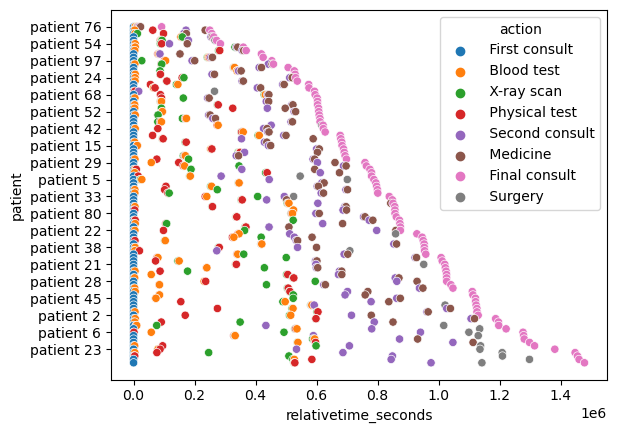

In [4]:
# Sort by case length:
events['case_length'] = events['case_end'] - events['case_start']
ordered = events.sort_values(by=['case_length', 'patient', 'relativetime_seconds'])
plt.yticks(np.arange(min(patients_numbers), max(patients_numbers)+1, 5))
sns.scatterplot(x=ordered['relativetime_seconds'], y=ordered['patient'], hue=ordered['action'])
plt.savefig('EventDistribution.png', bbox_inches='tight')
plt.show()

The dotted graph can also be used to determine the trend of events in absolute time, for example if instances arrive often or if there are trends on a weekly/daily basis.

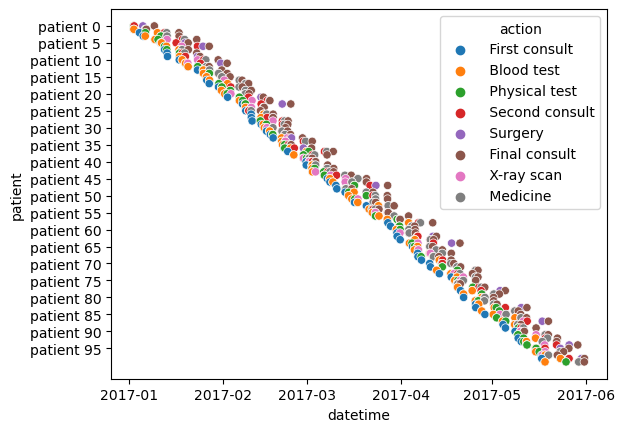

In [5]:
plt.yticks(np.arange(min(patients_numbers), max(patients_numbers)+1, 5))
sns.scatterplot(x=events['datetime'], y=events['patient'], hue=events['action'])
plt.show()

This shows a continuous influx of requests. Tracing events with resources also makes it possible to analyse events with resources.

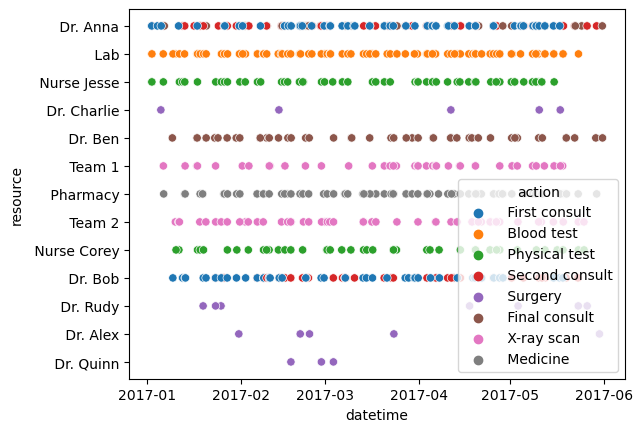

In [6]:
sns.scatterplot(x=events['datetime'], y=events['resource'], hue=events['action'])
plt.show()

Schedules must first be converted to days of the week to observe weekly trends.

In [7]:
events['weekday'] = events['datetime'].apply(lambda datetime: datetime.weekday())

This time, a jitter graph is preferable to a strip chart because the x-axis (day of the week) is categorical.

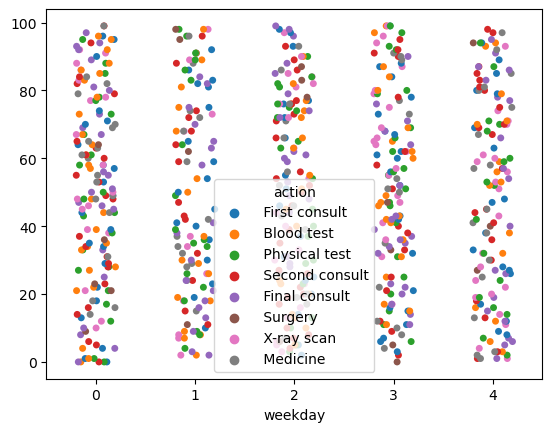

In [8]:
sns.stripplot(x=events['weekday'], y=patients_numbers, hue=events['action'], jitter=0.2)
plt.show()

Another thing to consider is which events are shared by all tasks and which are not, since in process mining we are interested in distinctive events that are not shared.

The following actions are common to all cases:  Blood test,  Final consult,  First consult,  Physical test,  Second consult
The following actions are the ones that we wish to keep (not common to all cases):  Medicine,  Surgery,  X-ray scan


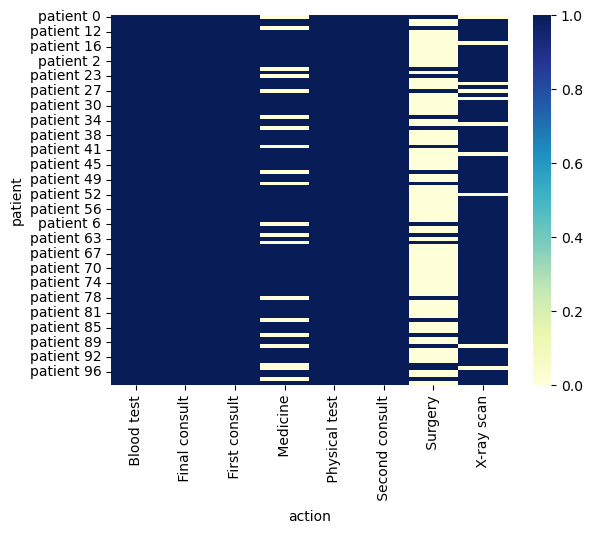

In [9]:
# Prepare a table listing the cases in which each event occurs:
patients_actions = pd.crosstab(events['patient'], events['action'])

# Determine the number of distinct event counts (if an event is shared by all patients, this value must be set to 1):
unique_actions = patients_actions.apply(pd.Series.nunique)
shared_actions = unique_actions[unique_actions==1].index
kept_actions = unique_actions[unique_actions>1].index
print('The following actions are common to all cases: {}'.format(', '.join(shared_actions)))
print('The following actions are the ones that we wish to keep (not common to all cases): {}'.format(', '.join(kept_actions)))

# Plot in a heat map:
sns.heatmap(patients_actions, cmap='YlGnBu')
plt.show()

First consult, blood test, second consult, physical test and final consult are the events shared by all patients, while medicine, surgery and x-ray scan are the differentiating events.

## Process Discovery

We need to map:

* the "patient" to the case, which is represented by the label "case:concept:name" in PM4Py;

* the "datetime" to the timestamp, which is represented by the label "time:timestamp" in PM4Py;

* the "action" to the event, which is represented by the label "concept:name" in PM4Py;

* the "resource" to the resource, which is represented by the label "org:resource" in PM4Py.

In [10]:
from pm4py.objects.conversion.log import converter
events.rename(columns={'datetime': 'time:timestamp', 'patient': 'case:concept:name', 'action': 'concept:name', 'resource': 'org:resource'}, inplace=True)
log = converter.apply(events)

Let us now begin using the PM4Py library to implement process discovery with the inductive miner. Inductive mining, like heuristic mining, ignores low-frequency events, isolated events and event loops. It also ensures soundness as an improvement in heuristics mining and alpha mining. Being solid indicates that the process model will always be safe, complete correctly and have the possibility of choosing to terminate, as well as that at least one of the process events will be executed. Therefore, a workflow network must fulfil the following criteria to be considered solid:

* safety;

* correct completion;

* possibility of termination;

* absence of dead parts.

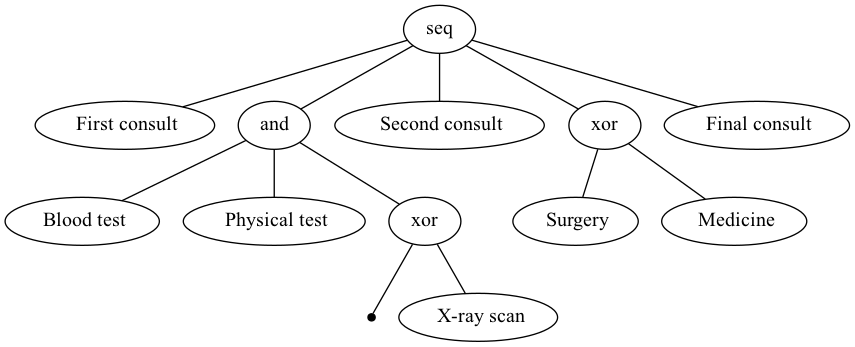

In [11]:
from pm4py.algo.discovery.inductive import algorithm
from pm4py.visualization.process_tree import visualizer
process_tree = algorithm.apply(log)
graph = visualizer.apply(process_tree)
visualizer.view(graph)
visualizer.save(graph, 'ProcessTree.png')

The corresponding Petri net representation can also be found, even if the process tree is the default internal representation of the process model.

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

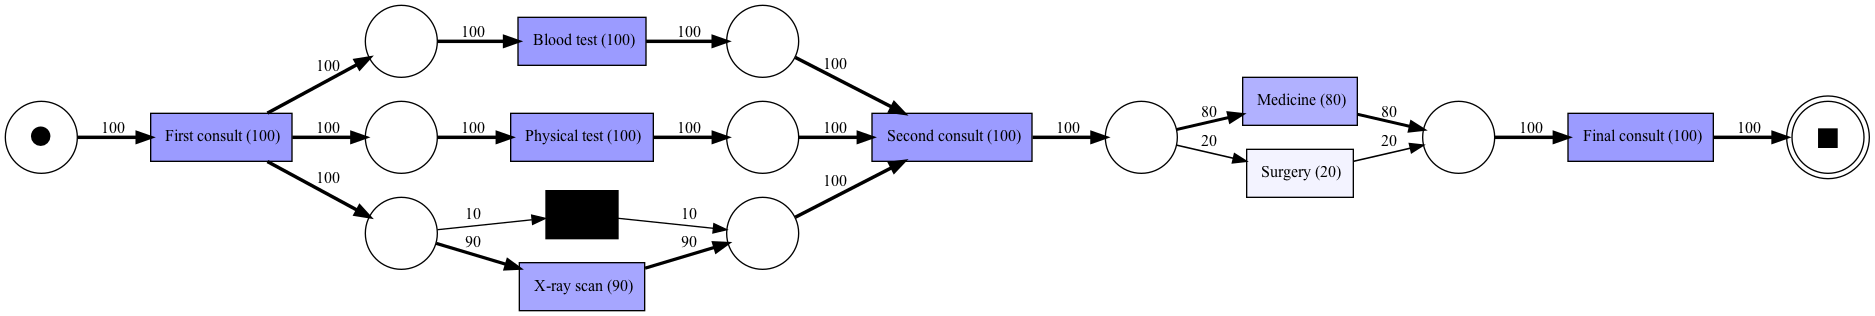

In [12]:
from pm4py.objects.conversion.process_tree import converter
from pm4py.visualization.petri_net import visualizer
petri_net, initial_marking, final_marking = converter.apply(process_tree, variant=converter.Variants.TO_PETRI_NET)
graph = visualizer.apply(petri_net, initial_marking, final_marking, log=log, variant=visualizer.Variants.FREQUENCY)
visualizer.view(graph)
visualizer.save(graph, 'PetriNet.png')

It is important to consider how the found model differ from the directly-follows graph of events and event transitions to better grasp what the process model are including and excluding.

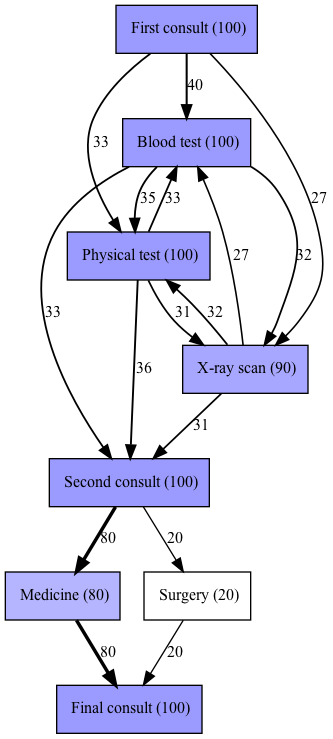

In [13]:
from pm4py.algo.discovery.dfg import algorithm
from pm4py.visualization.dfg import visualizer
directly_follows_graph = algorithm.apply(log)
graph = visualizer.apply(directly_follows_graph, log=log, variant=visualizer.Variants.FREQUENCY)
visualizer.view(graph)
visualizer.save(graph, 'DirectlyFollowsGraph.png')

As can be seen, the inductive miner failed to catch small loops, such as those between physical tests and blood tests.

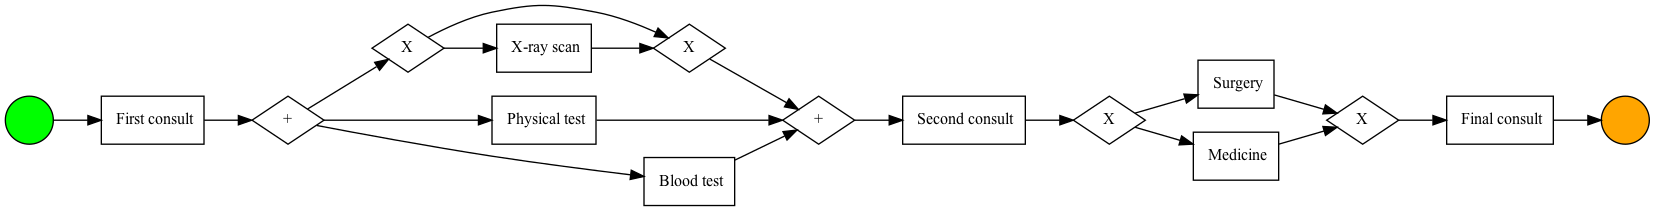

In [14]:
from pm4py.objects.conversion.process_tree import converter
from pm4py.objects.bpmn.exporter import exporter
from pm4py.visualization.bpmn import visualizer
business_process_modeling_notation = converter.apply(process_tree, variant=converter.Variants.TO_BPMN)
exporter.apply(business_process_modeling_notation, 'Healthcare.bpmn')
graph = visualizer.apply(business_process_modeling_notation)
visualizer.view(graph)
visualizer.save(graph, 'BusinessProcessModelingNotation.png')

We export the Business Process Modeling Notation (BPMN) because it is a standard graphical representation used to specify business processes.

## Conformance Checking

The identification of potential bottlenecks and inefficient event sequences can be done by performing an analysis of our process model.

In [15]:
from pm4py.objects.petri_net.utils import performance_map
traces = performance_map.get_transition_performance_with_token_replay(log, petri_net, initial_marking, final_marking)

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

The trace dictionary makes it possible to analyse the performance of individual cases, specific events and the workflows preceding them.

In [16]:
surgeries_matches = [key for key in traces if 'Surgery' in key]
surgeries_keys = surgeries_matches[0]
surgeries_times = traces[surgeries_keys]['all_values']

The distribution can also be plotted to help determine whether or not to carry out further research.

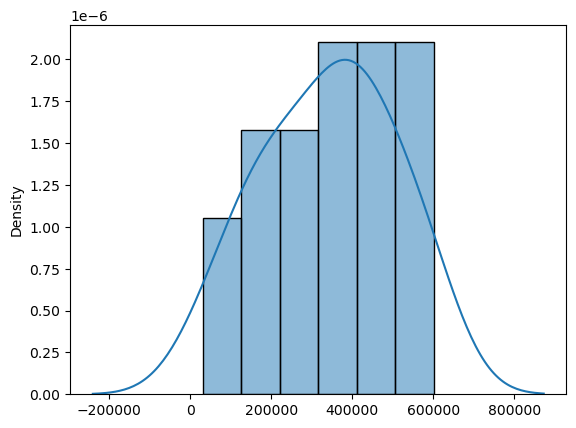

In [17]:
sns.histplot(surgeries_times, stat='density', kde=True, kde_kws=dict(cut=3))
plt.show()

By simply using a cross tabulation, it is possible to quickly see how resources are allocated.

In [18]:
events.rename(columns={'time:timestamp': 'datetime', 'case:concept:name': 'patient', 'concept:name': 'action', 'org:resource': 'resource'}, inplace=True)
pd.crosstab(events['action'], events['resource'])

resource,Dr. Alex,Dr. Anna,Dr. Ben,Dr. Bob,Dr. Charlie,Dr. Quinn,Dr. Rudy,Lab,Nurse Corey,Nurse Jesse,Pharmacy,Team 1,Team 2
action,,,,,,,,,,,,,
Blood test,0,0,0,0,0,0,0,100,0,0,0,0,0
Final consult,0,50,50,0,0,0,0,0,0,0,0,0,0
First consult,0,53,0,47,0,0,0,0,0,0,0,0,0
Medicine,0,0,0,0,0,0,0,0,0,0,80,0,0
Physical test,0,0,0,0,0,0,0,0,43,57,0,0,0
Second consult,0,55,0,45,0,0,0,0,0,0,0,0,0
Surgery,5,0,0,0,5,3,7,0,0,0,0,0,0
X-ray scan,0,0,0,0,0,0,0,0,0,0,0,40,50


To analyse the distribution of events for each resource, one can also normalise by column.

In [19]:
pd.crosstab(events['action'], events['resource'], normalize='columns')

resource,Dr. Alex,Dr. Anna,Dr. Ben,Dr. Bob,Dr. Charlie,Dr. Quinn,Dr. Rudy,Lab,Nurse Corey,Nurse Jesse,Pharmacy,Team 1,Team 2
action,,,,,,,,,,,,,
Blood test,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Final consult,0.0,0.316456,1.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
First consult,0.0,0.335443,0.0,0.51087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Medicine,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Physical test,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
Second consult,0.0,0.348101,0.0,0.48913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Surgery,1.0,0.000000,0.0,0.00000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
X-ray scan,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


Instead, to find out the percentage of events in a specific category for which each resource is responsible, it can be normalised by line.

In [20]:
pd.crosstab(events['action'], events['resource'], normalize='index')

resource,Dr. Alex,Dr. Anna,Dr. Ben,Dr. Bob,Dr. Charlie,Dr. Quinn,Dr. Rudy,Lab,Nurse Corey,Nurse Jesse,Pharmacy,Team 1,Team 2
action,,,,,,,,,,,,,
Blood test,0.00,0.00,0.0,0.00,0.00,0.00,0.00,1.0,0.00,0.00,0.0,0.000000,0.000000
Final consult,0.00,0.50,0.5,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.000000,0.000000
First consult,0.00,0.53,0.0,0.47,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.000000,0.000000
Medicine,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,1.0,0.000000,0.000000
Physical test,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.43,0.57,0.0,0.000000,0.000000
Second consult,0.00,0.55,0.0,0.45,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.000000,0.000000
Surgery,0.25,0.00,0.0,0.00,0.25,0.15,0.35,0.0,0.00,0.00,0.0,0.000000,0.000000
X-ray scan,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.444444,0.555556


In some situations, it may also be crucial to assess how resources are interlinked within a process and how resources are distributed between events.

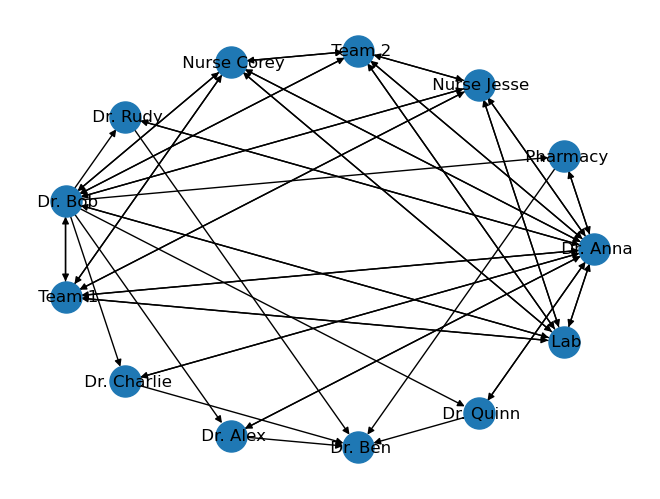

In [21]:
from pm4py.algo.organizational_mining.sna import algorithm
from pm4py.visualization.sna import visualizer
social_network_analysis = algorithm.log_handover.apply(log)
graph = visualizer.networkx.apply(social_network_analysis)
visualizer.networkx.view(graph)
visualizer.networkx.save(graph, 'SocialNetworkAnalysis.png')

The nodes of the network represent resources and direct links between them indicate a process in which one node moves after another (bi-directional links indicate that each of the resources could move towards the other).